In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from skgarden import MondrianForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pylab import rcParams

import pandas as pd

C:\Users\HakkyuKim\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\HakkyuKim\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
network = pd.read_csv('C:/Users/HakkyuKim/Desktop/yeonwoo/challenge/intial_trainig_stage.csv', index_col='date', parse_dates=['date'])
network.head()

network2 = pd.read_csv('C:/Users/HakkyuKim/Desktop/yeonwoo/challenge/intial_trainig_stage.csv')
network2.head()

network.describe()

,target
count,172800.000000
mean,428.157720
std,39.253344
min,241.308025
25%,402.000000
50%,426.000000
75%,452.000000
max,677.615002


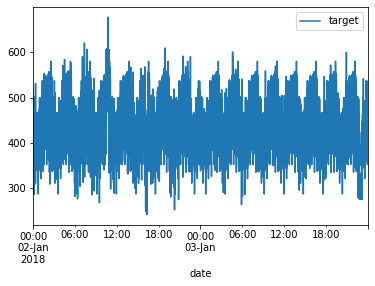

In [3]:
network.plot()

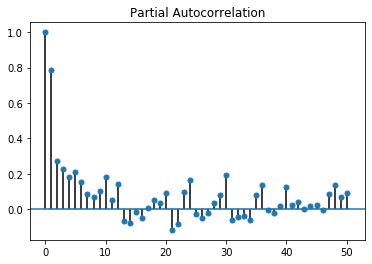

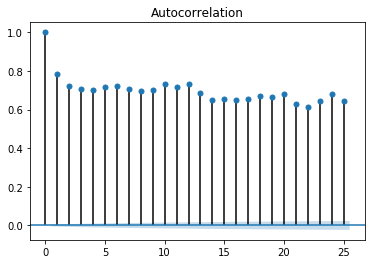

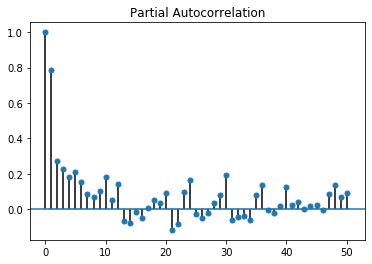

In [4]:
plot_acf(network, lags=25);
plot_pacf(network, lags=50)

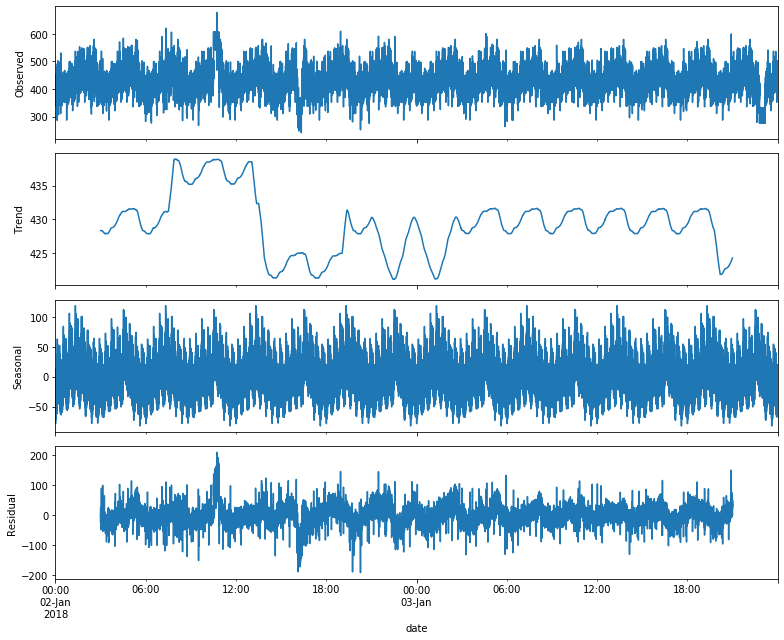

In [5]:
rcParams['figure.figsize'] = 11,9
decomposed_network = sm.tsa.seasonal_decompose(network, freq=21600)
figure = decomposed_network.plot()
plt.show()

,target
count,172799.000000
mean,0.000370
std,25.784710
min,-192.765426
25%,-17.000000
50%,0.000000
75%,17.000000
max,233.624171


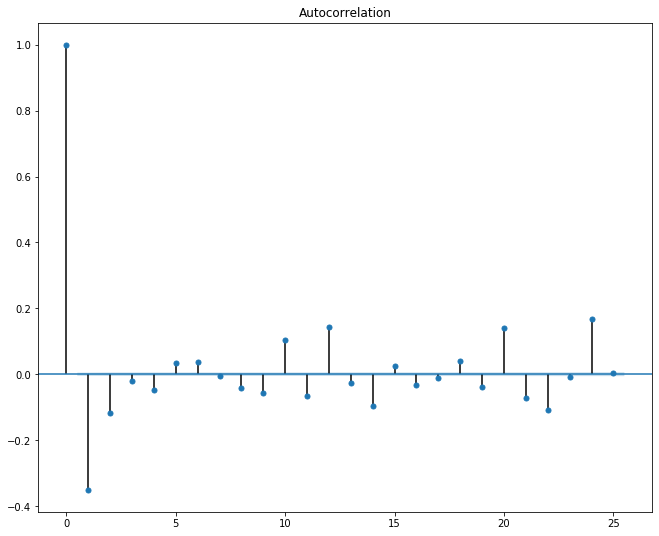

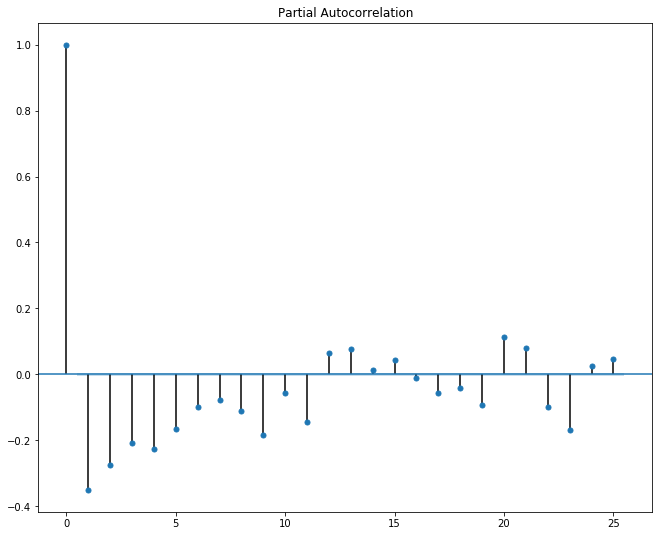

In [6]:
netdiff = network.diff()[1:]



plot_acf(netdiff, lags=25)
plot_pacf(netdiff, lags=25)

netdiff.describe()

C:\Users\HakkyuKim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)
C:\Users\HakkyuKim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D.target   No. Observations:               172799
Model:                 ARIMA(0, 1, 2)   Log Likelihood             -773858.071
Method:                       css-mle   S.D. of innovations             21.315
Date:                Fri, 06 Sep 2019   AIC                        1547724.142
Time:                        08:44:57   BIC                        1547764.381
Sample:                    01-02-2018   HQIC                       1547736.061
                         - 01-03-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0002      0.007      0.032      0.975      -0.013       0.014
ma.L1.D.target    -0.6539      0.002   -280.756      0.000      -0.658      -0.649
ma.L2.D.target    -0.2102      0.002

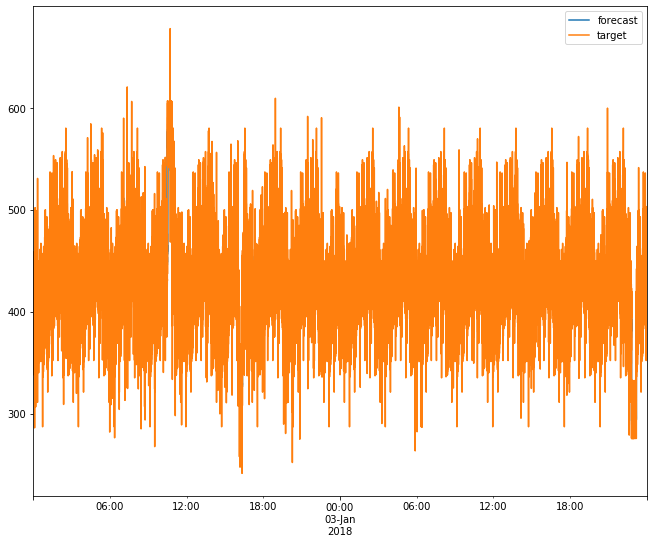

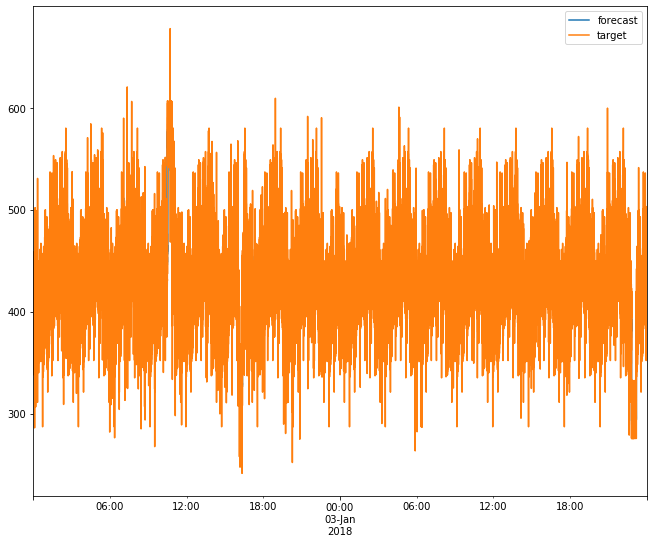

In [7]:
arima = ARIMA(network, order=(0, 1, 2))
result = arima.fit()
print(result.summary())

result.plot_predict()

In [8]:
idx = network.index

tmp = network.shift(1)
tmp2 = network.shift(2)
tmp3 = network.shift(3)

network_prev = network.copy()
network_prev['prev1'] = tmp['target']
network_prev['prev2'] = tmp2['target']
network_prev['prev3'] = tmp3['target']

network_prev = network_prev[4:]
network_prev.head()

,target,prev1,prev2,prev3
date,,,,
2018-01-02 00:00:04,361.0,341.0,388.0,397.0
2018-01-02 00:00:05,359.0,361.0,341.0,388.0
2018-01-02 00:00:06,369.0,359.0,361.0,341.0
2018-01-02 00:00:07,387.0,369.0,359.0,361.0
2018-01-02 00:00:08,415.0,387.0,369.0,359.0


In [30]:
def partial_train(mtr, X_test, y_test, X_prev, y_prev):
    mtr.partial_fit(X_prev, y_prev)
    X_prev = X_test
    y_prev = y_test
    
    y_pred, y_std = mtr.predict(X_test, return_std=True)
    
    #print('pred : %f, std: %f, y: %f'%(y_pred, y_std, y_test))
    return y_pred, y_std


In [26]:
X = network_prev[['prev1', 'prev2', 'prev3']]
y = network_prev['target']

X_train = X[:10000]
y_train = y[:10000]

X_test = X[10000:10001]
y_test = y[10000:10001]

print(X_test)


mtr = MondrianForestRegressor(random_state=1, n_estimators=100, bootstrap=True)
mtr.partial_fit(X_train, y_train)
y_pred, y_std = mtr.predict(X_test, return_std=True)

for next in range(10001, 12001):
    X_prev = X_test
    y_prev = y_test
    X_test = X[next:next+1]
    y_test = y[next:next+1]

    partial_train(mtr, X_test, y_test, X_prev, y_prev)
    
    



                     prev1  prev2  prev3
date                                    
2018-01-02 02:46:44  415.0  426.0  433.0
pred : 411.112679, std: 13.312159, y: 403.000000
pred : 407.912743, std: 14.023466, y: 402.000000
pred : 408.706634, std: 21.527410, y: 413.000000
pred : 403.921721, std: 21.507250, y: 446.000000
pred : 437.213608, std: 18.511212, y: 443.000000
pred : 439.753664, std: 23.646218, y: 429.000000
pred : 423.640393, std: 17.022640, y: 380.000000
pred : 397.699042, std: 17.590413, y: 448.000000
pred : 438.011208, std: 21.453234, y: 446.000000
pred : 438.646257, std: 30.572648, y: 407.000000
pred : 425.724031, std: 20.040915, y: 425.000000
pred : 430.065970, std: 12.282892, y: 408.000000
pred : 403.052791, std: 20.218872, y: 381.000000
pred : 404.144152, std: 16.048131, y: 394.000000
pred : 408.601341, std: 33.099928, y: 433.000000
pred : 423.766698, std: 19.622356, y: 438.000000
pred : 428.683163, std: 18.981374, y: 402.000000
pred : 417.853612, std: 23.215184, y: 411.00

pred : 402.000000, std: 0.000000, y: 402.000000
pred : 425.000000, std: 0.000000, y: 425.000000
pred : 401.000000, std: 0.000000, y: 401.000000
pred : 412.000000, std: 0.000000, y: 412.000000
pred : 398.000000, std: 0.000000, y: 398.000000
pred : 406.000000, std: 0.000000, y: 406.000000
pred : 409.000000, std: 0.000000, y: 409.000000
pred : 443.000000, std: 0.000000, y: 443.000000
pred : 405.000000, std: 0.000000, y: 405.000000
pred : 400.000000, std: 0.000000, y: 400.000000
pred : 394.000000, std: 0.000000, y: 394.000000
pred : 419.000000, std: 0.000000, y: 419.000000
pred : 396.000000, std: 0.000000, y: 396.000000
pred : 399.000000, std: 0.000000, y: 399.000000
pred : 386.000000, std: 0.000000, y: 386.000000
pred : 361.000000, std: 0.000000, y: 361.000000
pred : 402.000000, std: 0.000000, y: 402.000000
pred : 382.000000, std: 0.000000, y: 382.000000
pred : 388.000000, std: 0.000000, y: 388.000000
pred : 412.000000, std: 0.000000, y: 412.000000
pred : 365.000000, std: 0.000000, y: 365

pred : 390.000000, std: 0.000000, y: 390.000000
pred : 402.000000, std: 0.000000, y: 402.000000
pred : 442.000000, std: 0.000000, y: 442.000000
pred : 448.000000, std: 0.000000, y: 448.000000
pred : 441.000000, std: 0.000000, y: 441.000000
pred : 417.000000, std: 0.000000, y: 417.000000
pred : 403.000000, std: 0.000000, y: 403.000000
pred : 430.000000, std: 0.000000, y: 430.000000
pred : 398.000000, std: 0.000000, y: 398.000000
pred : 423.000000, std: 0.000000, y: 423.000000
pred : 409.000000, std: 0.000000, y: 409.000000
pred : 413.000000, std: 0.000000, y: 413.000000
pred : 422.000000, std: 0.000000, y: 422.000000
pred : 437.000000, std: 0.000000, y: 437.000000
pred : 407.000000, std: 0.000000, y: 407.000000
pred : 413.000000, std: 0.000000, y: 413.000000
pred : 393.000000, std: 0.000000, y: 393.000000
pred : 391.000000, std: 0.000000, y: 391.000000
pred : 415.000000, std: 0.000000, y: 415.000000
pred : 428.000000, std: 0.000000, y: 428.000000
pred : 415.000000, std: 0.000000, y: 415

pred : 398.000000, std: 0.000000, y: 398.000000
pred : 408.000000, std: 0.000000, y: 408.000000
pred : 491.000000, std: 0.000000, y: 491.000000
pred : 476.000000, std: 0.000000, y: 476.000000
pred : 447.000000, std: 0.000000, y: 447.000000
pred : 454.000000, std: 0.000000, y: 454.000000
pred : 447.000000, std: 0.000000, y: 447.000000
pred : 426.000000, std: 0.000000, y: 426.000000
pred : 397.000000, std: 0.000000, y: 397.000000
pred : 411.000000, std: 0.000000, y: 411.000000
pred : 419.000000, std: 0.000000, y: 419.000000
pred : 404.000000, std: 0.000000, y: 404.000000
pred : 432.000000, std: 0.000000, y: 432.000000
pred : 447.000000, std: 0.000000, y: 447.000000
pred : 439.000000, std: 0.000000, y: 439.000000
pred : 429.000000, std: 0.000000, y: 429.000000
pred : 397.000000, std: 0.000000, y: 397.000000
pred : 395.000000, std: 0.000000, y: 395.000000
pred : 397.000000, std: 0.000000, y: 397.000000
pred : 432.000000, std: 0.000000, y: 432.000000
pred : 416.000000, std: 0.000000, y: 416

pred : 410.000000, std: 0.000000, y: 410.000000
pred : 391.000000, std: 0.000000, y: 391.000000
pred : 372.000000, std: 0.000000, y: 372.000000
pred : 406.000000, std: 0.000000, y: 406.000000
pred : 394.000000, std: 0.000000, y: 394.000000
pred : 408.000000, std: 0.000000, y: 408.000000
pred : 387.000000, std: 0.000000, y: 387.000000
pred : 442.000000, std: 0.000000, y: 442.000000
pred : 442.000000, std: 0.000000, y: 442.000000
pred : 427.000000, std: 0.000000, y: 427.000000
pred : 409.000000, std: 0.000000, y: 409.000000
pred : 416.000000, std: 0.000000, y: 416.000000
pred : 415.000000, std: 0.000000, y: 415.000000
pred : 394.000000, std: 0.000000, y: 394.000000
pred : 416.000000, std: 0.000000, y: 416.000000
pred : 380.000000, std: 0.000000, y: 380.000000
pred : 403.000000, std: 0.000000, y: 403.000000
pred : 435.000000, std: 0.000000, y: 435.000000
pred : 426.000000, std: 0.000000, y: 426.000000
pred : 429.000000, std: 0.000000, y: 429.000000
pred : 401.000000, std: 0.000000, y: 401

pred : 421.000000, std: 0.000000, y: 421.000000
pred : 426.000000, std: 0.000000, y: 426.000000
pred : 423.000000, std: 0.000000, y: 423.000000
pred : 398.000000, std: 0.000000, y: 398.000000
pred : 428.000000, std: 0.000000, y: 428.000000
pred : 446.000000, std: 0.000000, y: 446.000000
pred : 418.000000, std: 0.000000, y: 418.000000
pred : 401.000000, std: 0.000000, y: 401.000000
pred : 378.000000, std: 0.000000, y: 378.000000
pred : 416.000000, std: 0.000000, y: 416.000000
pred : 425.000000, std: 0.000000, y: 425.000000
pred : 421.000000, std: 0.000000, y: 421.000000
pred : 426.000000, std: 0.000000, y: 426.000000
pred : 461.000000, std: 0.000000, y: 461.000000
pred : 448.000000, std: 0.000000, y: 448.000000
pred : 432.000000, std: 0.000000, y: 432.000000
pred : 422.000000, std: 0.000000, y: 422.000000
pred : 423.000000, std: 0.000000, y: 423.000000
pred : 425.000000, std: 0.000000, y: 425.000000
pred : 414.000000, std: 0.000000, y: 414.000000
pred : 437.000000, std: 0.000000, y: 437

pred : 457.000000, std: 0.000000, y: 457.000000
pred : 421.000000, std: 0.000000, y: 421.000000
pred : 417.000000, std: 0.000000, y: 417.000000
pred : 411.000000, std: 0.000000, y: 411.000000
pred : 411.000000, std: 0.000000, y: 411.000000
pred : 410.000000, std: 0.000000, y: 410.000000
pred : 429.000000, std: 0.000000, y: 429.000000
pred : 396.000000, std: 0.000000, y: 396.000000
pred : 427.000000, std: 0.000000, y: 427.000000
pred : 379.000000, std: 0.000000, y: 379.000000
pred : 400.000000, std: 0.000000, y: 400.000000
pred : 411.000000, std: 0.000000, y: 411.000000
pred : 407.000000, std: 0.000000, y: 407.000000
pred : 406.000000, std: 0.000000, y: 406.000000
pred : 452.000000, std: 0.000000, y: 452.000000
pred : 440.000000, std: 0.000000, y: 440.000000
pred : 419.000000, std: 0.000000, y: 419.000000
pred : 376.000000, std: 0.000000, y: 376.000000
pred : 431.000000, std: 0.000000, y: 431.000000
pred : 418.000000, std: 0.000000, y: 418.000000
pred : 435.000000, std: 0.000000, y: 435

pred : 381.000000, std: 0.000000, y: 381.000000
pred : 397.000000, std: 0.000000, y: 397.000000
pred : 401.000000, std: 0.000000, y: 401.000000
pred : 382.000000, std: 0.000000, y: 382.000000
pred : 373.000000, std: 0.000000, y: 373.000000
pred : 392.000000, std: 0.000000, y: 392.000000
pred : 365.000000, std: 0.000000, y: 365.000000
pred : 404.000000, std: 0.000000, y: 404.000000
pred : 386.000000, std: 0.000000, y: 386.000000
pred : 418.000000, std: 0.000000, y: 418.000000
pred : 384.000000, std: 0.000000, y: 384.000000
pred : 379.000000, std: 0.000000, y: 379.000000
pred : 394.000000, std: 0.000000, y: 394.000000
pred : 431.000000, std: 0.000000, y: 431.000000
pred : 392.000000, std: 0.000000, y: 392.000000
pred : 381.000000, std: 0.000000, y: 381.000000
pred : 362.000000, std: 0.000000, y: 362.000000
pred : 391.000000, std: 0.000000, y: 391.000000
pred : 389.000000, std: 0.000000, y: 389.000000
pred : 403.000000, std: 0.000000, y: 403.000000
pred : 420.000000, std: 0.000000, y: 420

pred : 369.000000, std: 0.000000, y: 369.000000
pred : 367.000000, std: 0.000000, y: 367.000000
pred : 366.000000, std: 0.000000, y: 366.000000
pred : 380.000000, std: 0.000000, y: 380.000000
pred : 389.000000, std: 0.000000, y: 389.000000
pred : 413.000000, std: 0.000000, y: 413.000000
pred : 411.000000, std: 0.000000, y: 411.000000
pred : 379.000000, std: 0.000000, y: 379.000000
pred : 395.000000, std: 0.000000, y: 395.000000
pred : 417.000000, std: 0.000000, y: 417.000000
pred : 435.000000, std: 0.000000, y: 435.000000
pred : 420.000000, std: 0.000000, y: 420.000000
pred : 377.000000, std: 0.000000, y: 377.000000
pred : 367.000000, std: 0.000000, y: 367.000000
pred : 353.000000, std: 0.000000, y: 353.000000
pred : 398.000000, std: 0.000000, y: 398.000000
pred : 392.000000, std: 0.000000, y: 392.000000
pred : 382.000000, std: 0.000000, y: 382.000000
pred : 390.500000, std: 8.500000, y: 382.000000
pred : 379.000000, std: 0.000000, y: 379.000000
pred : 383.000000, std: 0.000000, y: 383

pred : 399.000000, std: 0.000000, y: 399.000000
pred : 381.000000, std: 0.000000, y: 381.000000
pred : 375.000000, std: 0.000000, y: 375.000000
pred : 374.000000, std: 0.000000, y: 374.000000
pred : 397.000000, std: 0.000000, y: 397.000000
pred : 415.000000, std: 0.000000, y: 415.000000
pred : 370.000000, std: 0.000000, y: 370.000000
pred : 390.000000, std: 0.000000, y: 390.000000
pred : 381.000000, std: 0.000000, y: 381.000000
pred : 363.000000, std: 0.000000, y: 363.000000
pred : 385.000000, std: 0.000000, y: 385.000000
pred : 358.000000, std: 0.000000, y: 358.000000
pred : 410.000000, std: 0.000000, y: 410.000000
pred : 402.000000, std: 0.000000, y: 402.000000
pred : 385.000000, std: 0.000000, y: 385.000000
pred : 394.000000, std: 0.000000, y: 394.000000
pred : 416.000000, std: 0.000000, y: 416.000000
pred : 425.000000, std: 0.000000, y: 425.000000
pred : 409.000000, std: 0.000000, y: 409.000000
pred : 388.000000, std: 0.000000, y: 388.000000
pred : 383.000000, std: 0.000000, y: 383

pred : 372.000000, std: 0.000000, y: 372.000000
pred : 404.000000, std: 0.000000, y: 404.000000
pred : 421.000000, std: 0.000000, y: 421.000000
pred : 387.000000, std: 0.000000, y: 387.000000
pred : 372.000000, std: 0.000000, y: 372.000000
pred : 389.000000, std: 0.000000, y: 389.000000
pred : 374.000000, std: 0.000000, y: 374.000000
pred : 402.000000, std: 0.000000, y: 402.000000
pred : 378.000000, std: 0.000000, y: 378.000000
pred : 394.000000, std: 0.000000, y: 394.000000
pred : 388.000000, std: 25.000000, y: 363.000000
pred : 371.000000, std: 0.000000, y: 371.000000
pred : 391.000000, std: 0.000000, y: 391.000000
pred : 390.000000, std: 0.000000, y: 390.000000
pred : 390.000000, std: 0.000000, y: 390.000000
pred : 384.000000, std: 0.000000, y: 384.000000
pred : 381.000000, std: 0.000000, y: 381.000000
pred : 380.000000, std: 0.000000, y: 380.000000
pred : 375.000000, std: 0.000000, y: 375.000000
pred : 384.000000, std: 0.000000, y: 384.000000
pred : 375.000000, std: 0.000000, y: 37

pred : 412.000000, std: 0.000000, y: 412.000000
pred : 420.000000, std: 0.000000, y: 420.000000
pred : 417.000000, std: 0.000000, y: 417.000000
pred : 443.000000, std: 0.000000, y: 443.000000
pred : 405.000000, std: 0.000000, y: 405.000000
pred : 420.000000, std: 0.000000, y: 420.000000
pred : 390.000000, std: 0.000000, y: 390.000000
pred : 377.000000, std: 0.000000, y: 377.000000
pred : 381.000000, std: 0.000000, y: 381.000000
pred : 412.000000, std: 0.000000, y: 412.000000
pred : 439.000000, std: 0.000000, y: 439.000000
pred : 406.000000, std: 0.000000, y: 406.000000
pred : 414.000000, std: 0.000000, y: 414.000000
pred : 414.000000, std: 0.000000, y: 414.000000
pred : 392.000000, std: 0.000000, y: 392.000000
pred : 397.000000, std: 0.000000, y: 397.000000
pred : 385.000000, std: 0.000000, y: 385.000000
pred : 431.000000, std: 0.000000, y: 431.000000
pred : 376.000000, std: 0.000000, y: 376.000000
pred : 366.000000, std: 0.000000, y: 366.000000
pred : 390.000000, std: 0.000000, y: 390

In [27]:
network_prev1 = network.copy()
network_prev1['prev'] = tmp['target']

network_prev1 = network_prev1[1:]
network_prev1.head()

,target,prev
date,,
2018-01-02 00:00:01,397.0,367.0
2018-01-02 00:00:02,388.0,397.0
2018-01-02 00:00:03,341.0,388.0
2018-01-02 00:00:04,361.0,341.0
2018-01-02 00:00:05,359.0,361.0


In [36]:
X = network_prev1['prev'].values.reshape(-1, 1)
y = network_prev1['target']

X_train = X[:10000]
y_train = y[:10000]

X_test = X[10000:10001]
y_test = y[10000:10001]


mtr = MondrianForestRegressor(random_state=1, n_estimators=100, bootstrap=True)
mtr.partial_fit(X_train, y_train)
y_pred, y_std = mtr.predict(X_test, return_std=True)

prediction = np.array([y_pred])
stdeviation = np.array([y_std])


for next in range(10001, 12001):
    X_prev = X_test
    y_prev = y_test
    X_test = X[next:next+1]
    y_test = y[next:next+1]

    y_pred, y_std = partial_train(mtr, X_test, y_test, X_prev, y_prev)
    
    prediction = np.append(prediction, [y_pred])
    stdeviation = np.append(stdeviation, [y_std])
    
    


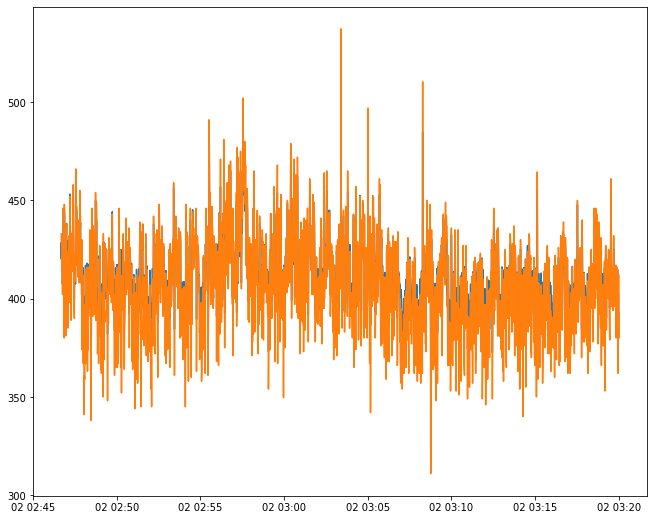

In [39]:
plt.plot(idx[10000:12001], prediction)
plt.plot(y[10000:12001])



In [42]:
resd = y[10000:12001] - prediction

resd.describe()

count    2001.000000
mean       -5.717770
std        22.745611
min       -95.785035
25%       -20.718445
50%        -6.176483
75%         9.137085
max       121.882906
Name: target, dtype: float64